# Run first: Define functions, load data and list of conserved genes

In [1]:
library(Seurat)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect




In [2]:
library(SeuratDisk)

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat



In [3]:
library(SeuratWrappers)

Warning message:
“package ‘SeuratWrappers’ was built under R version 4.3.1”


In [4]:
library(future)

In [5]:
library(here)

here() starts at /projects/pfenninggroup/singleCell/Macaque_SealDorsalHorn_snATAC-seq



In [6]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [7]:
library(dplyr)

In [8]:
library(cluster)

In [9]:
library(ggpubr)

In [10]:
library(ggplot2)

In [11]:
library(viridis)

Loading required package: viridisLite



In [12]:
#decision tree classification
library(rpart)


In [13]:
library(rpart.plot) #had to install

In [14]:
ss <- function(x, pattern, slot = 1, ...) { 
  sapply(strsplit(x = x, split = pattern, ...), '[', slot) }
options(stringsAsFactors = F)
options(repr.plot.width=11, repr.plot.height=8.5)
plan("multicore", workers = 28)
options(future.globals.maxSize = 100 * 1024^3)
options(future.rng.onMisuse = 'ignore')

In [15]:
# load datasets
filename = "/projects/pfenninggroup/singleCell/Macaque_SealDorsalHorn_snATAC-seq/data/tidy_data/rdas/mouse_rna_dh_conserved_names.h5seurat"
mouse_rna = LoadH5Seurat(filename)

filename = "/projects/pfenninggroup/singleCell/Macaque_SealDorsalHorn_snATAC-seq/data/tidy_data/rdas/human_rna_dh_conserved_names.h5seurat"
human_rna_dh = LoadH5Seurat(filename)

filename = "/projects/pfenninggroup/singleCell/Macaque_SealDorsalHorn_snATAC-seq/data/tidy_data/rdas/macaque_rna_dh_conserved_names.h5seurat"
macaque_rna_dh = LoadH5Seurat(filename)

Validating h5Seurat file

Initializing MAGIC_RNA with data

Adding miscellaneous information for MAGIC_RNA

Initializing MAGIC_SCT with data

Adding miscellaneous information for MAGIC_SCT

Initializing RNA with data

Adding counts for RNA

Adding miscellaneous information for RNA

Initializing SCT with data

Adding counts for SCT

Adding scale.data for SCT

Adding variable feature information for SCT

Adding miscellaneous information for SCT

Initializing alra with data

Adding scale.data for alra

Adding miscellaneous information for alra

Initializing integrated with data

Adding scale.data for integrated

Adding variable feature information for integrated

Adding miscellaneous information for integrated

Adding reduction pca

Adding cell embeddings for pca

Adding feature loadings for pca

Adding miscellaneous information for pca

Adding reduction umap

Adding cell embeddings for umap

Adding miscellaneous information for umap

Adding command information

Adding cell-level metadata

In [16]:
### mouse genes to human genes
convertHumanGeneList <- function(x){
  file = '/home/bnphan/resources/genomes/GRCh38.p13/ENSEMBL_GRCh38.p13_genes_to_Orthologous_mouse_genes.tsv'
  orthologs = read_tsv(file, show_col_types = FALSE) %>% 
    rename_with(make.names) %>% 
    dplyr::filter(Mouse.homology.type== 'ortholog_one2one') %>% 
    dplyr::filter(Mouse.gene.name %in% x) %>% 
    dplyr::select(Mouse.gene.name, Gene.name)
  
  # Print the first 6 genes found to the screen
  print(head(orthologs))
  return(orthologs)
}

In [17]:
# RenameGenesSeurat from https://github.com/satijalab/seurat/issues/1049
RenameGenesSeurat <- function(obj, newnames) {
  # Replace gene names in different slots of a Seurat object. Run this before integration.
  # It only changes obj@assays$RNA@counts, @data and @scale.data.
  print("Run this before integration. It only changes obj@assays$RNA@counts, @data and @scale.data.")
  RNA <- obj@assays$RNA

  if (nrow(RNA) == length(newnames)) {
    if (length(RNA@counts)) RNA@counts@Dimnames[[1]]            <- newnames
    if (length(RNA@data)) RNA@data@Dimnames[[1]]                <- newnames
    if (length(RNA@scale.data)) RNA@scale.data@Dimnames[[1]]    <- newnames
  } else {"Unequal gene sets: nrow(RNA) != nrow(newnames)"}
  obj@assays$RNA <- RNA
  return(obj)
}

In [18]:
## switch out human gene names w/ orthologous mouse gene names, based on ENSEMBL
MmtoHg = convertHumanGeneList(rownames(mouse_rna)) %>% deframe()
HgtoMm = setNames(names(MmtoHg), MmtoHg)

# A tibble: 6 × 2
  Mouse.gene.name Gene.name
  <chr>           <chr>    
1 Frg1            NA       
2 Usp9y           USP9Y    
3 Usp9y           USP9Y    
4 Usp9y           USP9Y    
5 Usp9y           USP9Y    
6 Usp9y           USP9Y    


In [19]:
#Final set of features
features = c('BNC2','HMGA2','NMUR2','PREX2','NMU','TAC3',' COL5A2', 'PLCH1','LMO3', 'TRPC3','SKOR2', 'NELL2','MAF','ADARB2', 'MAFA', 'NTS','TSHZ2', 'SNTB1', 'TRH','DACH1','PBX3','SLIT2',
            'CACNA2D3','TCF4', 'SORCS1','SDK1', 'PDZD2','SGCD', 'NPY','ZIC1', 'MEF2C','RORB','NXPH1', 'SDK2','PDYN','PTPRK')
mouse_features = as.character(HgtoMm[features])

macaque_ordered_types = c('GLUT1','GLUT2','GLUT3','GLUT4','GLUT5','GLUT6','GLUT7','GLUT8','GLUT9','GLUT10','GLUT11',
                          'GABA1','GABA2_1','GABA2_2','GABA3','GABA4_2','GABA4_1','GABA5')
new_cell_names = c('Exc-BNC2/HMGA2','Exc-NMUR2/PREX2', 'Exc-NMU/TAC3', 'Exc-TAC3/COL5A2/PLCH1','Exc-LMO3/TRPC3', 'Exc-SKOR2/NELL2', 'Exc-MAF/ADARB2', 'Exc-MAFA/BNC2', 
                  'Exc-NTS/TSHZ2', 'Exc-SNTB1/TRH/DACH1', 'Exc-PBX3/SLIT2', 
                  'Inh-CACNA2D3/TCF4', 'Inh-SORCS1/SDK1', 'Inh-PDZD2/SGCD', 'Inh-NPY/ZIC1', 'Inh-MEF2C/RORB','Inh-NXPH1/SDK2','Inh-PDYN/PTPRK')

names(new_cell_names) = macaque_ordered_types
new_cell_nicknames = c('Exc-BNC2','Exc-NMUR2', 'Exc-NMU', 'Exc-TAC3','Exc-LMO3', 'Exc-SKOR2', 'Exc-MAF', 'Exc-MAFA', 
                  'Exc-NTS', 'Exc-SNTB1', 'Exc-PBX3', 'Inh-CACNA2D3', 'Inh-SORCS1', 'Inh-PDZD2', 'Inh-NPY', 'Inh-MEF2C','Inh-NXPH1','Inh-PDYN')
names(new_cell_nicknames) = macaque_ordered_types

Idents(object = mouse_rna) <- factor(x = mouse_rna$conserved_marker_nicknames, levels = new_cell_nicknames)
Idents(object = macaque_rna_dh) <- factor(x = macaque_rna_dh$conserved_marker_nicknames, levels = new_cell_nicknames)
Idents(object = human_rna_dh) <- factor(x = human_rna_dh$conserved_marker_nicknames, levels = new_cell_nicknames)

# Get gene x cell matrices and labels. Do for all species

In [20]:
# row = gene, column = individual cell
mouse_assay <- GetAssay(mouse_rna)
mouse_assay['data'][1:2,1:2]
# labels for classification
mouse_labels = mouse_rna$conserved_marker_nicknames
table(mouse_labels)

2 x 2 sparse Matrix of class "dgCMatrix"
       SRR6040902_GTAGCTGGGGCN SRR6040902_CTTTTTGCCTGG
Xkr4                  2.498829                3.143528
Gm1992                1.095364                1.564861

mouse_labels
    Exc-BNC2     Exc-LMO3      Exc-MAF     Exc-MAFA      Exc-NMU    Exc-NMUR2 
         176          291          447          126          278          285 
     Exc-NTS     Exc-PBX3    Exc-SKOR2    Exc-SNTB1     Exc-TAC3 Inh-CACNA2D3 
         154          184          219           95            1          267 
   Inh-MEF2C      Inh-NPY    Inh-NXPH1     Inh-PDYN    Inh-PDZD2   Inh-SORCS1 
         188          205          169          340          175          268 

In [21]:
# row = gene, column = individual cell
human_assay <- GetAssay(human_rna_dh)
human_assay['data'][1:2,1:2]
# labels for classification
human_labels = human_rna_dh$conserved_marker_nicknames
table(human_labels)

2 x 2 sparse Matrix of class "dgCMatrix"
          AAATGGATCAGAATAG-1_H1 AACAGGGAGCGAGGAG-1_H1
FAM87B                        .                     .
LINC00115                     .                     .

human_labels
    Exc-BNC2     Exc-LMO3      Exc-MAF     Exc-MAFA      Exc-NMU    Exc-NMUR2 
          54           69           77           27           93          146 
     Exc-NTS     Exc-PBX3    Exc-SKOR2    Exc-SNTB1 Inh-CACNA2D3    Inh-MEF2C 
          49           14           64           44           75           88 
     Inh-NPY    Inh-NXPH1     Inh-PDYN    Inh-PDZD2   Inh-SORCS1 
          57           44          146           14           41 

In [22]:
# row = gene, column = individual cell
macaque_assay <- GetAssay(macaque_rna_dh)
macaque_assay['data'][1:2,1:2]
# labels for classification
macaque_labels = macaque_rna_dh$conserved_marker_nicknames
table(macaque_labels)

2 x 2 sparse Matrix of class "dgCMatrix"
         1 2
MTND2P28 . .
MTCO1P12 . .

macaque_labels
    Exc-BNC2     Exc-LMO3      Exc-MAF     Exc-MAFA      Exc-NMU    Exc-NMUR2 
         142          105          124           76          152          222 
     Exc-NTS     Exc-PBX3    Exc-SKOR2    Exc-SNTB1     Exc-TAC3 Inh-CACNA2D3 
          98           89          123           62           49          109 
   Inh-MEF2C      Inh-NPY    Inh-NXPH1     Inh-PDYN    Inh-PDZD2   Inh-SORCS1 
          91           74          100          202           71           65 

In [23]:
list_all_cell_types <- c("Exc-BNC2","Exc-LMO3","Exc-MAF","Exc-MAFA","Exc-NMU","Exc-NMUR2","Exc-NTS","Exc-PBX3","Exc-SKOR2","Exc-SNTB1","Inh-CACNA2D3","Inh-MEF2C","Inh-NPY","Inh-NXPH1","Inh-PDYN","Inh-PDZD2","Inh-SORCS1")

In [24]:
cell_type_marker_genes <- list("Exc-BNC2" = c("BNC2","HMGA2"), "Exc-LMO3" = c("LMO3","TRPC3"), "Exc-MAF" = c("MAF","ADARB2"), "Exc-MAFA" = c("MAFA","BNC2"), "Exc-NMU" = c("NMU","TAC3"), "Exc-NMUR2" = c("NMUR2","PREX2"), "Exc-NTS" = c("NTS","TSHZ2"), "Exc-PBX3" = c("PBX3","SLIT2"), "Exc-SKOR2" = c("SKOR2","NELL2"), "Exc-SNTB1" = c("SNTB1","TRH","DACH1"), "Inh-CACNA2D3" = c("CACNA2D3","TCF4"), "Inh-MEF2C" = c("MEF2C","RORB"), "Inh-NPY" = c("NPY","ZIC1"), "Inh-NXPH1" = c("NXPH1","SDK2"), "Inh-PDYN" = c("PDYN","PTPRK"), "Inh-PDZD2" = c("PDZD2","SGCD"), "Inh-SORCS1" = c("SORCS1","SDK1"))

# Interpretable classification modeling with a small number of variables: Decision tree construction
Note: Use new_cell_names as the guide for which genes to use per cell type

Goal: Using the two (sometimes three) marker genes previously identified, 
construct decision trees to classify that cell type versus others. Do this for all three species.
Method: Decision trees are supported in R. For example: https://www.r-bloggers.com/2021/04/decision-trees-in-r/
Split cells into training and validation sets (however this is done in R)
Limit the trees to two decisions deep maximum (use both genes but not overly complicated)

Why? If decision trees work well to classify cell types cross-species, then we have more quantitative evidence that these are good marker genes.
Extra bonus: We should probably figure out how to make this more statistically rigorous. One way is to select two/three random genes a bunch of times and then construct decision trees that way. Our conserved markers should always be a lot better. This only works if the decision tree implementation in R is fast. Similarly, we could do random sampling of cells for training and validation (bootstrapping) and see how results are affected.

Another method besides decision tree would also be fine if it's not too complicated

In [25]:
myclassify2 <- function(orig_df, macaque_labels, features_list, key,human_df,human_labels,mouse_df,mouse_labels) {
    
    print(key)
    print(features_list)
    subset_data <- orig_df[c(features_list), , drop = FALSE]
    transposed_matrix <- Matrix::t(subset_data)
    subset_df <- as.data.frame(as.matrix(transposed_matrix))
    subset_df_with_label <- data.frame(subset_df, cell_label = macaque_labels)
    subset_df_with_label$cell_label <- ifelse(subset_df_with_label$cell_label == key, "1", "0")
    subset_df_with_label$cell_label <- factor(subset_df_with_label$cell_label, levels = c("1", "0"))

    set.seed(12)

    sample <- sample(c(TRUE, FALSE), nrow(subset_df_with_label), replace=TRUE, prob=c(0.8,0.2))
    train_df <- subset_df_with_label[sample, ]
    test_df <- subset_df_with_label[!sample, ]
    
    #create the mouse and human subsets
    
    #human subset
    human_subset_data <- human_df[c(features_list), , drop = FALSE]
    human_transposed_matrix <- Matrix::t(human_subset_data)
    human_subset_df <- as.data.frame(as.matrix(human_transposed_matrix))
    human_subset_df_with_label <- data.frame(human_subset_df, cell_label = human_labels)
    human_subset_df_with_label$cell_label <- ifelse(human_subset_df_with_label$cell_label == key, "1", "0")
    human_subset_df_with_label$cell_label <- factor(human_subset_df_with_label$cell_label, levels = c("1", "0"))
    
    #mouse subset
    mouse_subset_data <- mouse_df[c(features_list), , drop = FALSE]
    mouse_transposed_matrix <- Matrix::t(mouse_subset_data)
    mouse_subset_df <- as.data.frame(as.matrix(mouse_transposed_matrix))
    mouse_subset_df_with_label <- data.frame(mouse_subset_df, cell_label = mouse_labels)
    mouse_subset_df_with_label$cell_label <- ifelse(mouse_subset_df_with_label$cell_label == key, "1", "0")
    mouse_subset_df_with_label$cell_label <- factor(mouse_subset_df_with_label$cell_label, levels = c("1", "0"))
    
    #model training
    tree <- rpart(cell_label ~., data = train_df, maxdepth = 2)
    #rpart.plot(tree)
    
    #train_df prediction
    print(paste0("macaque train prediction ", key))
    p <- predict(tree, train_df, type = 'class')
    conf_matrix <- table(Actual = train_df$cell_label, Predicted = p)
    print("train dataset confusion matrix")
    print(conf_matrix)
    correct_predictions <- sum(diag(conf_matrix))
    total_predictions <- sum(conf_matrix)
    accuracy <- correct_predictions / total_predictions
    print(paste("Accuracy of train_df:", accuracy))
    
    #test_df prediction
    print(paste0("macaque test prediction ", key))
    p2 <- predict(tree, test_df, type = 'class')
    conf_matrix2 <- table(Actual = test_df$cell_label, Predicted = p2)
    print("test dataset confusion matrix")
    print(conf_matrix2)
    correct_predictions2 <- sum(diag(conf_matrix2))
    total_predictions2 <- sum(conf_matrix2)
    accuracy2 <- correct_predictions2 / total_predictions2
    print(paste("Accuracy of test_df:", accuracy2))
    
    #human_df prediction
    print(paste0("human prediction ", key))
    p3 <- predict(tree, human_subset_df_with_label, type = 'class')
    conf_matrix3 <- table(Actual = human_subset_df_with_label$cell_label, Predicted = p3)
    print("human dataset confusion matrix")
    print(conf_matrix3)
    correct_predictions3 <- sum(diag(conf_matrix3))
    total_predictions3 <- sum(conf_matrix3)
    accuracy3 <- correct_predictions3 / total_predictions3
    print(paste("Accuracy of human data:", accuracy3))
    
    #mouse_df prediction
    print(paste0("mouse prediction ", key))
    p4 <- predict(tree, mouse_subset_df_with_label, type = 'class')
    conf_matrix4 <- table(Actual = mouse_subset_df_with_label$cell_label, Predicted = p4)
    print("mouse dataset confusion matrix")
    print(conf_matrix4)
    correct_predictions4 <- sum(diag(conf_matrix4))
    total_predictions4 <- sum(conf_matrix4)
    accuracy4 <- correct_predictions4 / total_predictions4
    print(paste("Accuracy of mouse data:", accuracy4))
    
    result_list <- list(acc1 = conf_matrix, acc2 = conf_matrix2, acc3 = conf_matrix3, acc4 = conf_matrix4)
  
    # Return the list
    return(result_list)
    
    #boundary(tree, test_df, class = "cell_label", main = "Decision Tree")
}

In [26]:
orig_df = macaque_assay['data']
human_df = human_assay['data']
mouse_df = mouse_assay['data']
rownames(mouse_df) <- toupper(rownames(mouse_df))
rownames(mouse_df)[rownames(mouse_df) == 'TAC2'] <- 'TAC3'

list_train_macaque_acc <- list() 
list_test_macaque_acc <- list()
list_human_acc <- list()
list_mouse_acc <- list()
list_cell_type <- list()

# Iterate through the dictionary
for (key in names(cell_type_marker_genes)) {
    
    list_cell_type <- append(list_cell_type, key)
    
    
    features_list <- cell_type_marker_genes[[key]]
    
    result <- myclassify2(orig_df, macaque_labels, features_list, key, human_df,human_labels,mouse_df,mouse_labels)
    
    list_train_macaque_acc <- append(list_train_macaque_acc, result$acc1)
    list_test_macaque_acc <- append(list_test_macaque_acc, result$acc2)
    list_human_acc <- append(list_human_acc, result$acc3)
    list_mouse_acc <- append(list_mouse_acc, result$acc4)
  }

[1] "Exc-BNC2"
[1] "BNC2"  "HMGA2"
[1] "macaque train prediction Exc-BNC2"
[1] "train dataset confusion matrix"
      Predicted
Actual    1    0
     1   75   37
     0    1 1491
[1] "Accuracy of train_df: 0.976309226932668"
[1] "macaque test prediction Exc-BNC2"
[1] "test dataset confusion matrix"
      Predicted
Actual   1   0
     1  19  11
     0   0 320
[1] "Accuracy of test_df: 0.968571428571429"
[1] "human prediction Exc-BNC2"
[1] "human dataset confusion matrix"
      Predicted
Actual    1    0
     1   43   11
     0   26 1022
[1] "Accuracy of human data: 0.966424682395644"
[1] "mouse prediction Exc-BNC2"
[1] "mouse dataset confusion matrix"
      Predicted
Actual    1    0
     1  136   40
     0   25 3667
[1] "Accuracy of mouse data: 0.983195449844881"
[1] "Exc-LMO3"
[1] "LMO3"  "TRPC3"
[1] "macaque train prediction Exc-LMO3"
[1] "train dataset confusion matrix"
      Predicted
Actual    1    0
     1   80    3
     0    6 1515
[1] "Accuracy of train_df: 0.994389027431421"
[

In [27]:
create_metric_df <- function(orig_list, vec_cell_type) {
    
    vecn <- unlist(orig_list)
    tp_vecn <- vecn[seq(1, length(vecn), by = 4)]
    fp_vecn <- vecn[seq(2, length(vecn), by = 4)]
    fn_vecn <- vecn[seq(3, length(vecn), by = 4)]
    tn_vecn <- vecn[seq(4, length(vecn), by = 4)]
    
    #calc. accuracy
    acc_vec <- (tp_vecn + tn_vecn) / (tp_vecn + fp_vecn + fn_vecn + tn_vecn)
    
    #calc. sensitivity/recall
    recall_vec <- tp_vecn / (tp_vecn + fn_vecn)
    
    #calc. specificity
    spec_vec <- tn_vecn / (tn_vecn + fp_vecn)
    
    #calc. precison/positive predictive value
    prec_vec <- tp_vecn / (tp_vecn + fp_vecn)
    
    #calc. negative predictive value
    npv_vec <- tn_vecn / (tn_vecn + fn_vecn)
    
    
    metric_df <- data.frame (
    #Cell_Type = vec_cell_type,
    True_Positive = tp_vecn,
    False_Positive = fp_vecn,
    False_Negative = fn_vecn,
    True_Negative = tn_vecn,
    Accuracy = acc_vec,
    Recall_or_Sensitivity = recall_vec,
    Specificity = spec_vec,
    Precision_or_PPV = prec_vec,
    NPV = npv_vec 
    )
    
    #rownames(metric_df) <- metric_df$Cell_Type
    #metric_df$Cell_Type <- NULL
    
    rownames(metric_df) <- vec_cell_type
    return(metric_df)
    
    }

In [28]:
vec_cell_type <- unlist(list_cell_type)
vec_cell_type

[1] "Exc-BNC2"     "Exc-LMO3"     "Exc-MAF"      "Exc-MAFA"     "Exc-NMU"     
 [6] "Exc-NMUR2"    "Exc-NTS"      "Exc-PBX3"     "Exc-SKOR2"    "Exc-SNTB1"   
[11] "Inh-CACNA2D3" "Inh-MEF2C"    "Inh-NPY"      "Inh-NXPH1"    "Inh-PDYN"    
[16] "Inh-PDZD2"    "Inh-SORCS1"

In [29]:
macaque_train_metrics_df <- create_metric_df(list_train_macaque_acc, vec_cell_type)
print(macaque_train_metrics_df)

             True_Positive False_Positive False_Negative True_Negative
Exc-BNC2                75              1             37          1491
Exc-LMO3                80              6              3          1515
Exc-MAF                101              1              1          1501
Exc-MAFA                63              7              3          1531
Exc-NMU                128              7              2          1467
Exc-NMUR2              172              1             13          1418
Exc-NTS                 64              4             17          1519
Exc-PBX3                67              1              9          1527
Exc-SKOR2               80              1             26          1497
Exc-SNTB1               46             11              3          1544
Inh-CACNA2D3            75             21             13          1495
Inh-MEF2C               46              2             24          1532
Inh-NPY                 58              0              5          1541
Inh-NX

In [30]:
macaque_test_metrics_df <- create_metric_df(list_test_macaque_acc, vec_cell_type)
print(macaque_test_metrics_df)

             True_Positive False_Positive False_Negative True_Negative
Exc-BNC2                19              0             11           320
Exc-LMO3                22              0              0           328
Exc-MAF                 22              1              0           327
Exc-MAFA                 8              0              2           340
Exc-NMU                 22              2              0           326
Exc-NMUR2               37              2              0           311
Exc-NTS                 12              0              5           333
Exc-PBX3                11              0              2           337
Exc-SKOR2               11              0              6           333
Exc-SNTB1               11              1              2           336
Inh-CACNA2D3            21              7              0           322
Inh-MEF2C               12              0              9           329
Inh-NPY                 11              0              0           339
Inh-NX

In [31]:
human_metrics_df <- create_metric_df(list_human_acc, vec_cell_type)
print(human_metrics_df)

             True_Positive False_Positive False_Negative True_Negative
Exc-BNC2                43             26             11          1022
Exc-LMO3                52             12             17          1021
Exc-MAF                 67             12             10          1013
Exc-MAFA                25             90              2           985
Exc-NMU                 78              4             15          1005
Exc-NMUR2              131             72             15           884
Exc-NTS                 43             17              6          1036
Exc-PBX3                 6            171              8           917
Exc-SKOR2               39            113             25           925
Exc-SNTB1               42             56              2          1002
Inh-CACNA2D3            74            381              1           646
Inh-MEF2C                8             72             80           942
Inh-NPY                 47             25             10          1020
Inh-NX

In [32]:
mouse_metrics_df <- create_metric_df(list_mouse_acc, vec_cell_type)
print(mouse_metrics_df)

             True_Positive False_Positive False_Negative True_Negative
Exc-BNC2               136             25             40          3667
Exc-LMO3               134             39            157          3538
Exc-MAF                429            320             18          3101
Exc-MAFA                 4              0            122          3742
Exc-NMU                243             58             35          3532
Exc-NMUR2              248             70             37          3513
Exc-NTS                146            113              8          3601
Exc-PBX3               168            715             16          2969
Exc-SKOR2              142            128             77          3521
Exc-SNTB1               93             31              2          3742
Inh-CACNA2D3           260           1284              7          2317
Inh-MEF2C               10            419            178          3261
Inh-NPY                 49              3            156          3660
Inh-NX

In [59]:
write.csv(macaque_train_metrics_df,"riya_dtree_dorsal_macaque_train_metrics.csv", row.names = TRUE)
write.csv(macaque_test_metrics_df,"riya_dtree_dorsal_macaque_test_metrics.csv", row.names = TRUE)
write.csv(human_metrics_df,"riya_dtree_dorsal_human_metrics.csv", row.names = TRUE)
write.csv(mouse_metrics_df,"riya_dtree_dorsal_mouse_metrics.csv", row.names = TRUE)

# Decision tree evaluation
Evaluate using standard ML metrics for classification, and make confusion matrices. Closely related cell types will probably be the source of most errors, which we can show.

Visualize the actual trees for extra interpretability.


In [126]:
boundary <- function(model, data, class = NULL, predict_type = "class",
                      resolution = 100, showgrid = TRUE, ...) {

    
  if (!is.null(class)) cl <- data[, class] else cl <- 1
  data <- data[, 1:2]
  k <- length(unique(cl))

  # Set up a layout with extra space for the legend
  layout(matrix(c(1, 2), nrow = 1), widths = c(0.8, 0.2))

  # Plot the data
  plot(data, col = as.integer(cl) + 1L, pch = as.integer(cl) + 1L, xaxt = "n",yaxt = "n",cex.lab=1.5, ...)

  # make grid
  r <- sapply(data, range, na.rm = TRUE)
  xs <- seq(r[1, 1], r[2, 1], length.out = resolution)
  ys <- seq(r[1, 2], r[2, 2], length.out = resolution)
  g <- cbind(rep(xs, each = resolution), rep(ys, time = resolution))
  colnames(g) <- colnames(r)
  g <- as.data.frame(g)

  ### guess how to get class labels from predict
  ### (unfortunately not very consistent between models)
  p <- predict(model, g, type = predict_type)
  if (is.list(p)) p <- p$class
  p <- as.factor(p)

  if (showgrid) points(g, col = as.integer(p) + 1L, pch = ".")

  z <- matrix(as.integer(p), nrow = resolution, byrow = TRUE)
  contour(xs, ys, z, add = TRUE, drawlabels = FALSE,
          lwd = 2, levels = (1:(k - 1)) + 0.5)

  # Plot the legend in the second part of the layout
  par(mar = c(5, 0, 5, 0))  # Adjust margins for the legend
  plot.new()
  legend("top", legend = levels(p), col = 1:k+1, pch = 1:k+1, title = "Classes",
         xpd = TRUE, bty = "n", inset = c(0, 0), cex = 1.5)

  
  invisible(z)
  
}


In [127]:
boundary2 <- function(model, data, class = NULL, predict_type = "class",
                      resolution = 100, showgrid = TRUE, ...) {

    
  if (!is.null(class)) cl <- data[, class] else cl <- 1
  data <- data[, 1:2]
  k <- length(unique(cl))

  # Set up a layout with extra space for the legend
  layout(matrix(c(1, 2), nrow = 1), widths = c(0.8, 0.2))

  # Plot the data
  plot(data, col = as.integer(cl) + 1L, pch = as.integer(cl) + 1L, xaxt = "n",yaxt = "n",cex.lab=1.5,...)

  # make grid
  r <- sapply(data, range, na.rm = TRUE)
  xs <- seq(r[1, 1], r[2, 1], length.out = resolution)
  ys <- seq(r[1, 2], r[2, 2], length.out = resolution)
  g <- cbind(rep(xs, each = resolution), rep(ys, time = resolution))
  colnames(g) <- colnames(r)
  g <- as.data.frame(g)

  ### guess how to get class labels from predict
  ### (unfortunately not very consistent between models)
  p <- predict(model, g, type = predict_type)
  if (is.list(p)) p <- p$class
  p <- as.factor(p)

  if (showgrid) points(g, col = as.integer(p) + 1L, pch = ".")

  z <- matrix(as.integer(p), nrow = resolution, byrow = TRUE)
  contour(xs, ys, z, add = TRUE, drawlabels = FALSE,
          lwd = 2, levels = (1:(k - 1)) + 0.5)

  
  invisible(z)
  
}


In [132]:
myclassify3 <- function(orig_df, macaque_labels, features_list, key,human_df,human_labels,mouse_df,mouse_labels) {
    
    print(key)
    print(features_list)
    subset_data <- orig_df[c(features_list), , drop = FALSE]
    transposed_matrix <- Matrix::t(subset_data)
    subset_df <- as.data.frame(as.matrix(transposed_matrix))
    subset_df_with_label <- data.frame(subset_df, cell_label = macaque_labels)
    subset_df_with_label$cell_label <- ifelse(subset_df_with_label$cell_label == key, "1", "0")
    subset_df_with_label$cell_label <- factor(subset_df_with_label$cell_label, levels = c("1", "0"))

    set.seed(12)

    sample <- sample(c(TRUE, FALSE), nrow(subset_df_with_label), replace=TRUE, prob=c(0.8,0.2))
    train_df <- subset_df_with_label[sample, ]
    test_df <- subset_df_with_label[!sample, ]
    
    #create the mouse and human subsets
    
    #human subset
    human_subset_data <- human_df[c(features_list), , drop = FALSE]
    human_transposed_matrix <- Matrix::t(human_subset_data)
    human_subset_df <- as.data.frame(as.matrix(human_transposed_matrix))
    human_subset_df_with_label <- data.frame(human_subset_df, cell_label = human_labels)
    human_subset_df_with_label$cell_label <- ifelse(human_subset_df_with_label$cell_label == key, "1", "0")
    human_subset_df_with_label$cell_label <- factor(human_subset_df_with_label$cell_label, levels = c("1", "0"))
    
    #mouse subset
    mouse_subset_data <- mouse_df[c(features_list), , drop = FALSE]
    mouse_transposed_matrix <- Matrix::t(mouse_subset_data)
    mouse_subset_df <- as.data.frame(as.matrix(mouse_transposed_matrix))
    mouse_subset_df_with_label <- data.frame(mouse_subset_df, cell_label = mouse_labels)
    mouse_subset_df_with_label$cell_label <- ifelse(mouse_subset_df_with_label$cell_label == key, "1", "0")
    mouse_subset_df_with_label$cell_label <- factor(mouse_subset_df_with_label$cell_label, levels = c("1", "0"))
    
    #model training
    tree <- rpart(cell_label ~., data = train_df, maxdepth = 2)
    #rpart.plot(tree)
    
    #train_df prediction
    #boundary(tree, train_df, class = "cell_label", main = "Decision Tree macaque train")
    
    
    #test_df prediction
    boundary(tree, test_df, class = "cell_label", main = "Decision Tree macaque test")
   
    
    #human_df prediction
    boundary2(tree, human_subset_df_with_label, class = "cell_label", main = "Decision Tree human")
    
    
    #mouse_df prediction
    boundary2(tree, mouse_subset_df_with_label, class = "cell_label", main = "Decision Tree mouse")
    
}

[1] "Exc-BNC2"
[1] "BNC2"  "HMGA2"


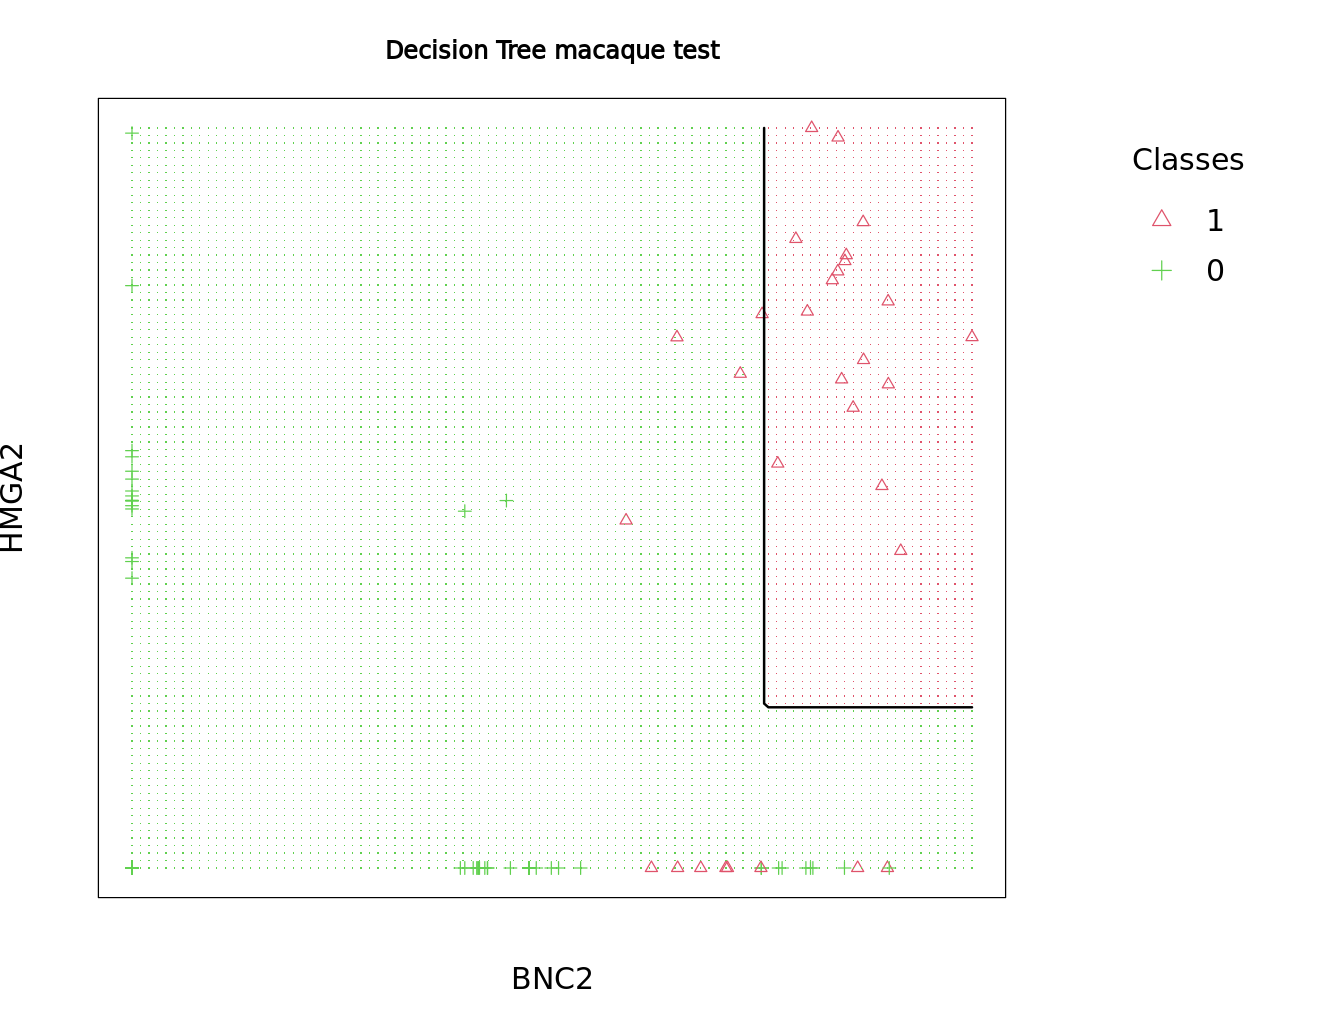

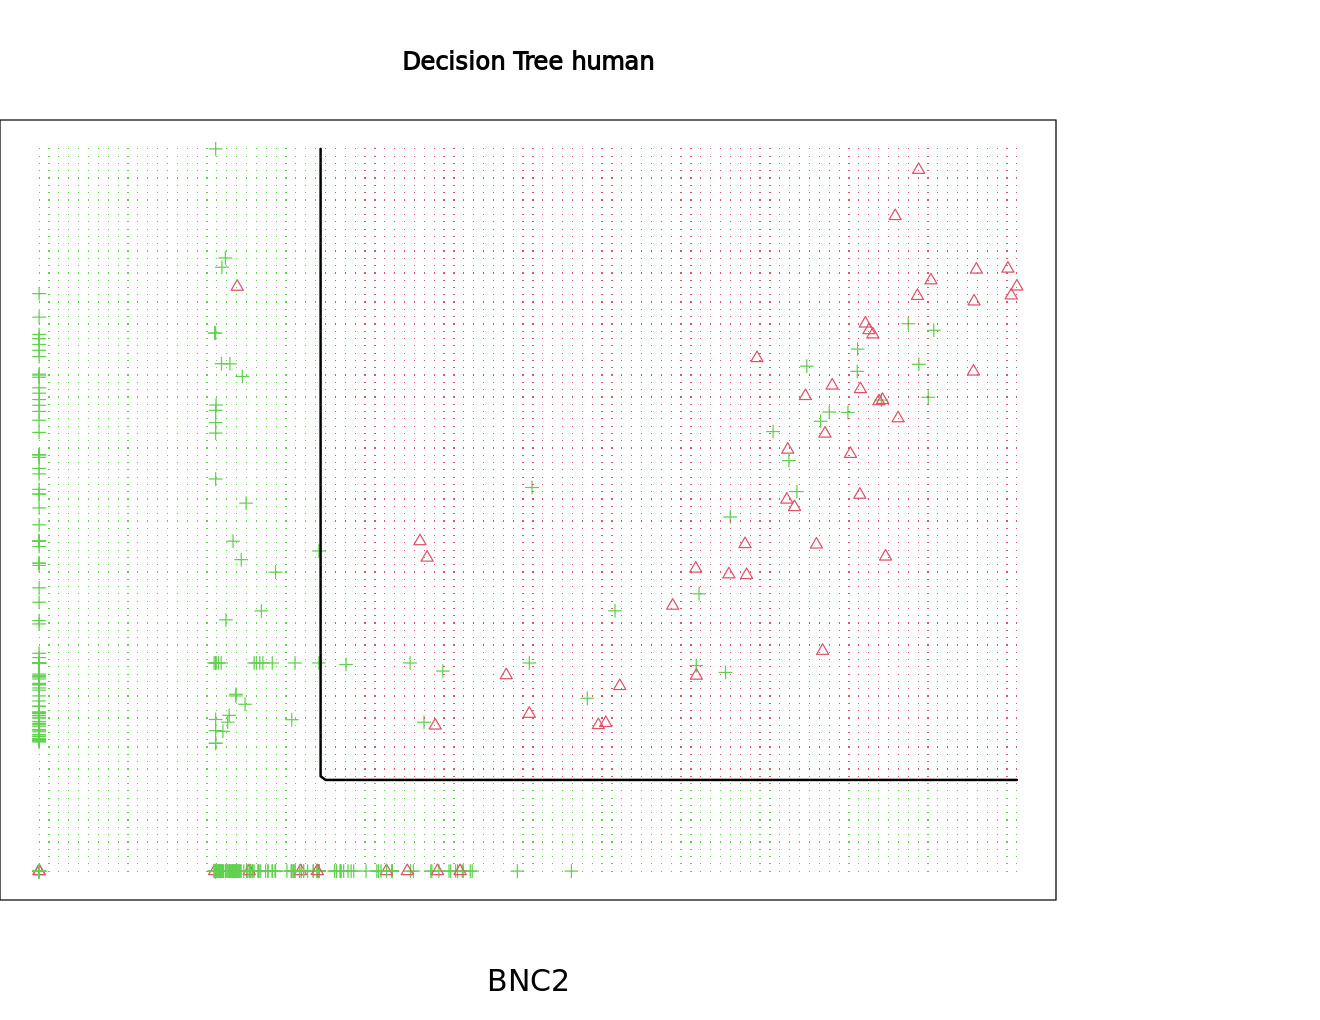

[1] "Inh-PDYN"
[1] "PDYN"  "PTPRK"


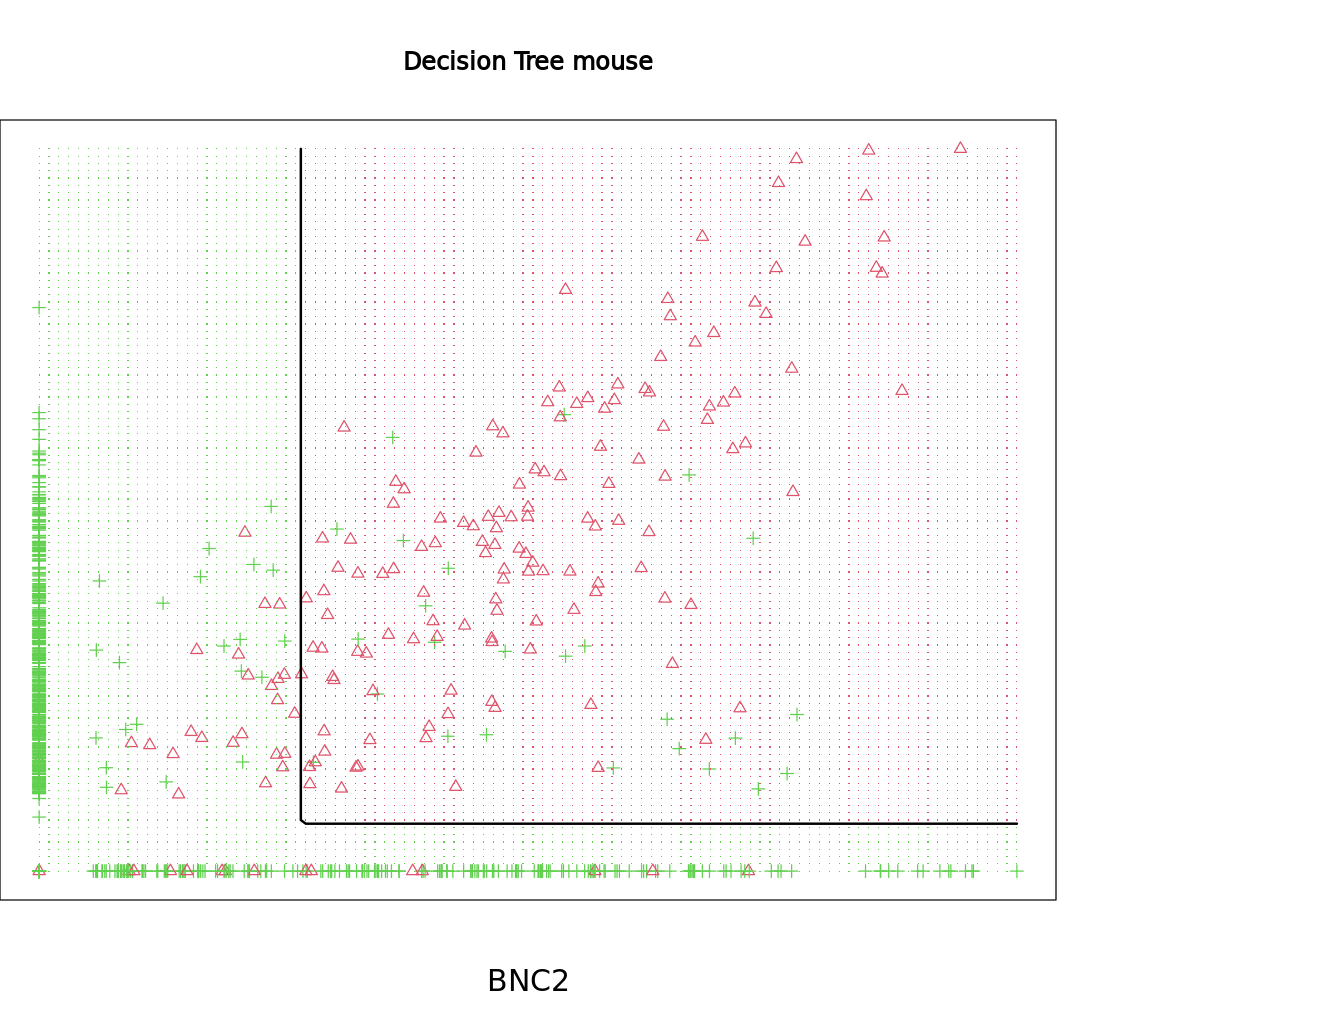

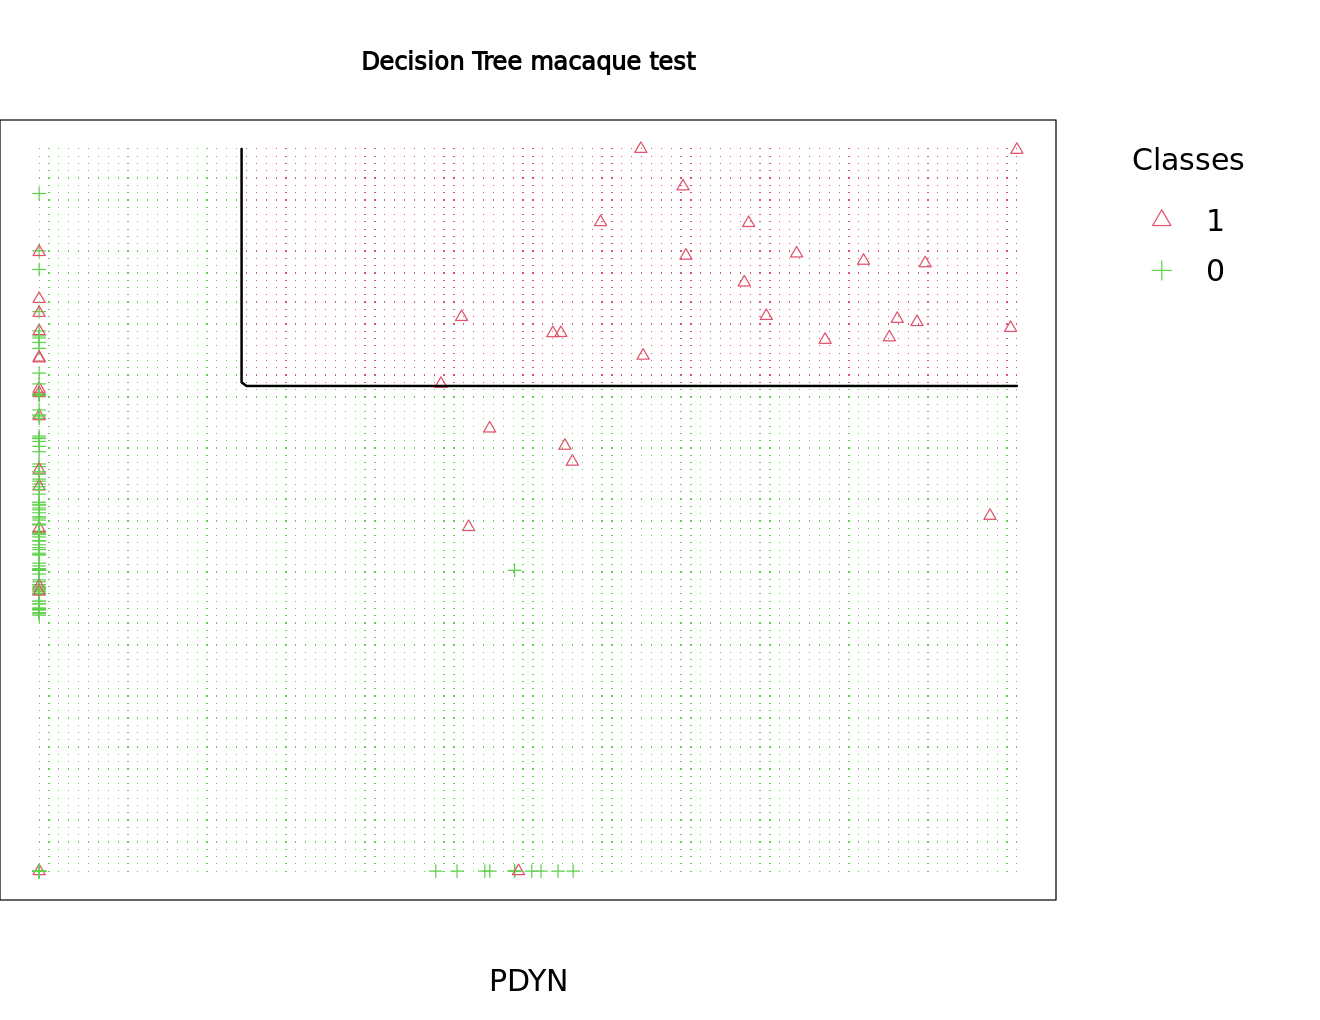

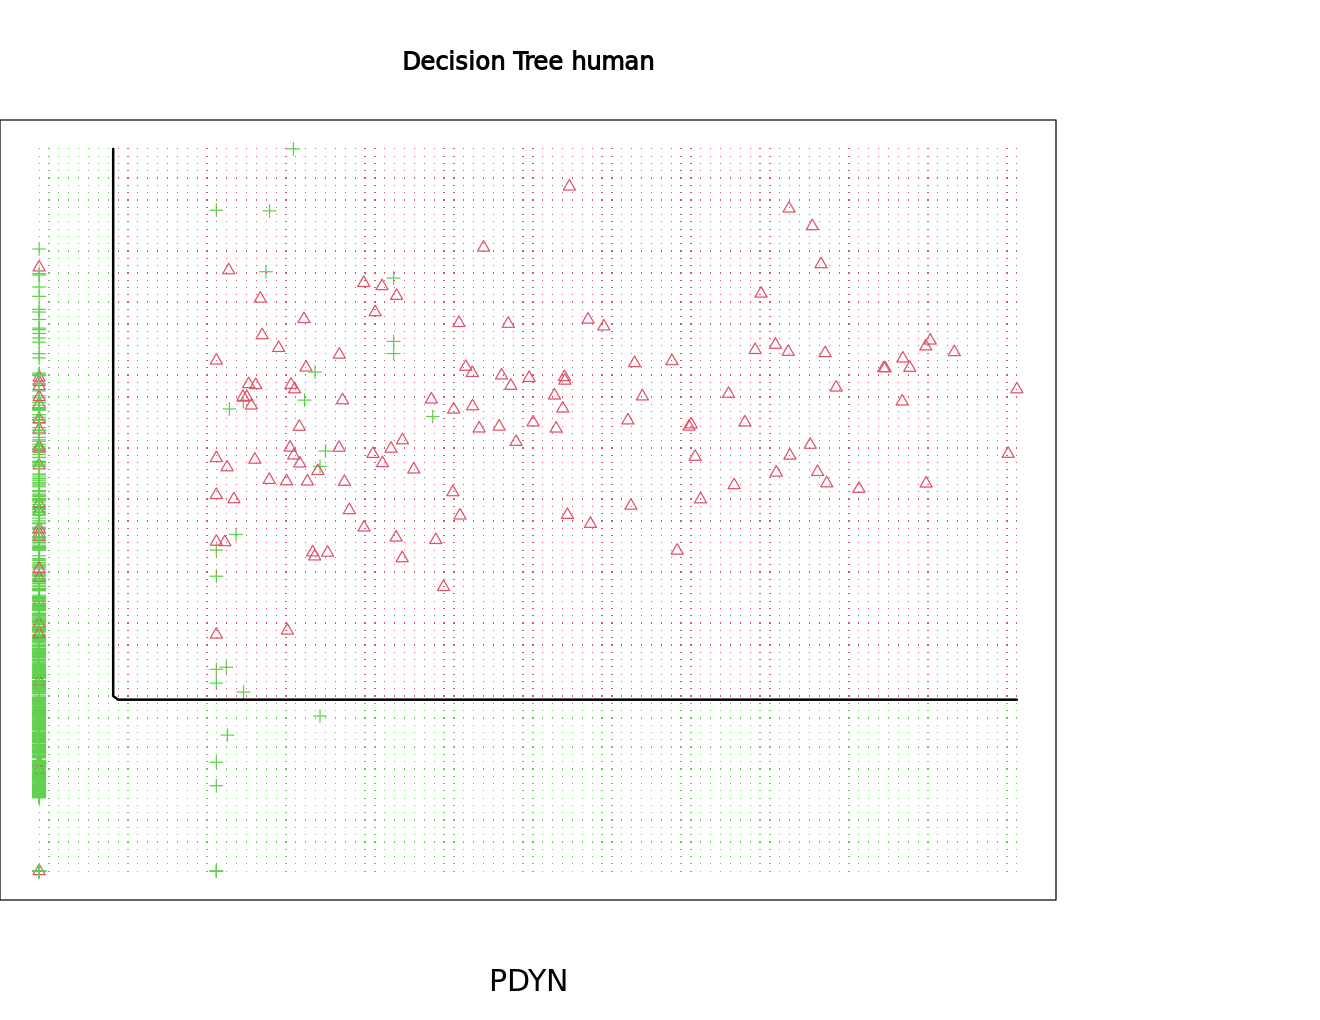

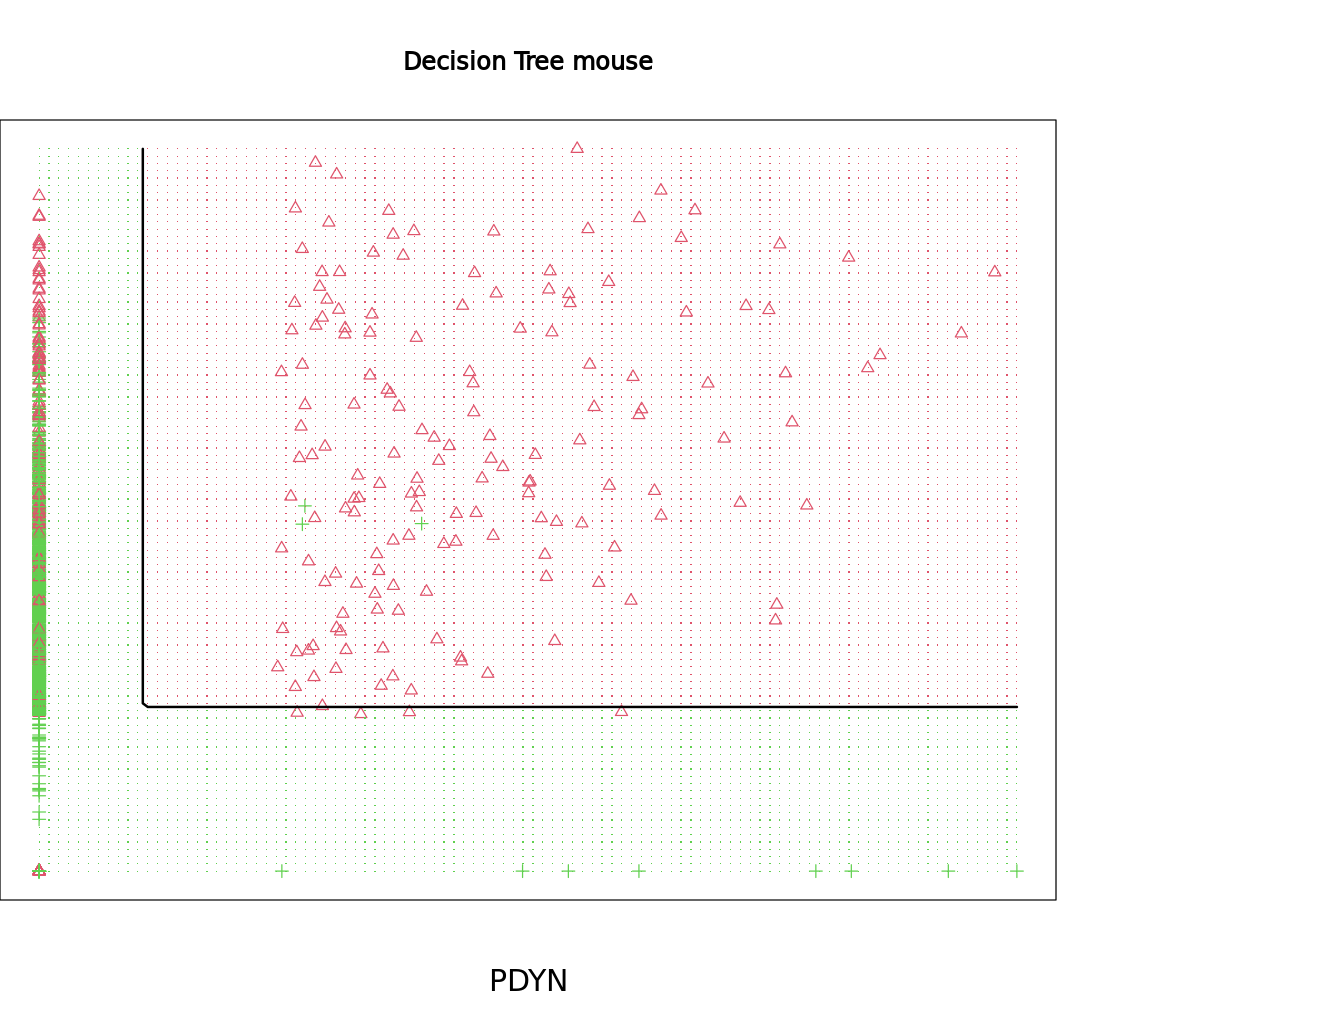

In [133]:
sample_list_cell_type <- list()
sample_cell_type_marker_genes <- list("Exc-BNC2" = c("BNC2","HMGA2"),"Inh-PDYN" = c("PDYN","PTPRK"))
# Iterate through the dictionary
for (key in names(sample_cell_type_marker_genes)) {
    
    sample_list_cell_type <- append(sample_list_cell_type, key)
    
    
    features_list <- sample_cell_type_marker_genes[[key]]
    
    myclassify3(orig_df, macaque_labels, features_list, key, human_df,human_labels,mouse_df,mouse_labels)
  
  }

In [ ]:
myclassify <- function(orig_df, mouse_labels, features_list, key) {
    
    subset_data <- orig_df[c(features_list), , drop = FALSE]
    transposed_matrix <- Matrix::t(subset_data)
    subset_df <- as.data.frame(as.matrix(transposed_matrix))
    subset_df_with_label <- data.frame(subset_df, cell_label = mouse_labels)
    subset_df_with_label$cell_label <- ifelse(subset_df_with_label$cell_label == key, "1", "0")
    subset_df_with_label$cell_label <- factor(subset_df_with_label$cell_label, levels = c("1", "0"))
    #subset_df_with_label <- subset(subset_df_with_label, !(Pdyn == 0 & Ptprk == 0))
    set.seed(12)

    sample <- sample(c(TRUE, FALSE), nrow(subset_df_with_label), replace=TRUE, prob=c(0.8,0.2))
    train_df <- subset_df_with_label[sample, ]
    test_df <- subset_df_with_label[!sample, ]
    
    tree <- rpart(cell_label ~., data = train_df, maxdepth = 2)
    rpart.plot(tree)
    
    boundary(tree, test_df, class = "cell_label", main = "Decision Tree")
}